## Instructions to run this notebook
After login in your google account, you will need to add the following google drive folder to your drive as a shortcut.

- Open the folder below: <br>
📂 [Files to analyse the distance to green areas](https://drive.google.com/drive/folders/1QX8gTEIADCqXM7QUIYR1xIPU3MKT_oTN)

<br>

- Add the folder as a shortcut within your Google Drive (check the image below):
<img src="https://drive.google.com/uc?id=130md31KHOq0CWPx5hEyDmV_jdv8ODHGU">

<br>

- Allow the Colab to access your Google Drive when an authorizarion is required. After that, run cell by cell.

In [1]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# setting the folders where files are located
rootFolder = '/content/drive/MyDrive/urbVerdeDistToGreen_version_1/'

# folders where general data and sp data are located
subFolders = [
    'urbVerde_exports_distToGreen',
    'urbVerde_exports_distToGreen_sp'
    ]

# path to shp files
shpFilesPath = rootFolder + 'shapefilesDistToGreen/'

# shapefile of census tracts
censusTractsPath = shpFilesPath + 'census tracts/urbanSetCens_2022_sp.shp'

# municipalities
munPath = shpFilesPath + 'SP_Municipios_2024/SP_Municipios_2024.shp'

In [3]:
# importing pandas, os, and numpy (basics)
import pandas as pd
import os
import numpy as np

# importing geo packages
import geopandas as gpd

# importing matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# importing seaborn
import seaborn as sns

# importing packages to plot municipalities dinamically
from ipywidgets import widgets, interact, interactive
from IPython.display import display, clear_output, HTML

# importing folium for interative map
import folium

# colormap to plot a 'legend' along with folium maps
import branca.colormap as cm

In [4]:
# reading the csv files of distance to green by census tracts

# setting a list where dataframes will be saved
dfsToMerge = []

# walking through the sub folders
for subFolder in subFolders:

  # setting the complete folder path
  folder_path = rootFolder + subFolder

  # walking throught the files
  for root, _, files in os.walk(folder_path):
    for file in files:
      if file.endswith('.csv'):
        file_path = os.path.join(root, file)
        df = pd.read_csv(file_path)

        # pushing the df into the list of dfs
        dfsToMerge.append(df)

# concatenating all the dataframes
df_merged = pd.concat(dfsToMerge, ignore_index = True)

# # uncomment to see the df
# # checking it
# df_merged.head()

In [5]:
# reading the shapefile of census tracts
gdf_uct = gpd.read_file(censusTractsPath)

# # uncomment to see the gdf
# gdf_uct.head()

In [6]:
# convert the 'CD_SETOR' column in df_merged to string type to match gdf_uct
df_merged['CD_SETOR'] = df_merged['CD_SETOR'].astype(str)

# merging gdf and df
gdf_dtg = gdf_uct.merge(df_merged, left_on="CD_SETOR", right_on="CD_SETOR")

# # uncomment to see the gdf
# gdf_dtg.head()

In [7]:
# general info to plot (visualization parameters)
columns = [
    'distance_to_greenAreas_lt_5000m2',
    'distance_to_greenAreas_gte_5000m2',
    'distance_to_nearest_greenArea'
]

columnsDict = {
    'distance_to_greenAreas_lt_5000m2': 'LT 5000 m2',
    'distance_to_greenAreas_gte_5000m2': 'GTE 5000 m2',
    'distance_to_nearest_greenArea': 'Nearest Green Area',
}

# setting the colorscale
vmin = 0
vmax = 800

# setting a colormap
cmap = plt.cm.RdYlGn_r
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# dropdown for municipality selection
colMunName = 'NM_MUN_y'

# list of municipalities
municipalities = gdf_dtg[colMunName].unique().tolist()
dropdown = widgets.Dropdown(
    options=sorted(municipalities),
    description='Municipality:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Create a linear color map matching the data range
folColMap = cm.LinearColormap(
    colors=[mcolors.to_hex(cmap(norm(v))) for v in np.linspace(vmin,vmax, 5)],
    vmin=vmin,
    vmax=vmax
)

In [60]:
# just updating the gdf variable
gdf=gdf_dtg

# plotting using folium
def plot_folium_map(mun):

  # filter the geodataframe considering the selected municipality
  gdf_selected = gdf[gdf[colMunName] == mun]

  # set the crs to a projected crs (UTM) to center the map
  gdf_projected = gdf_selected.to_crs(epsg=5880)

  # get the center
  center = gdf_projected.geometry.centroid.iloc[0]

  # center lat/lon crs for folium map
  center_latLong = gpd.GeoSeries([center], crs=gdf_projected.crs).to_crs(epsg=4326).geometry.iloc[0]

  # get the lat/lon back for folium
  gdf_selected = gdf_selected.to_crs(epsg=4326)

  # finally creating the map using folium
  m = folium.Map(location=[center_latLong.y, center_latLong.x], zoom_start=12, tiles='CartoDB positron', width=800, height=600)
  # m = folium.Map(location=[center_latLong.y, center_latLong.x], zoom_start=12, tiles='OpenStreetMap', width=800, height=600)

  # here, we plot each layer to be selected to view on the map
  for col in columns:

    # here, it is necessary to create a function to set the colors of the plot
    def setting_style (col=col):
      return lambda feature: {
          'fillColor': mcolors.to_hex(cmap(norm(feature['properties'][col]))), #cmap(feature['properties'][col]),
          'color': 'black',
          'weight': 0,
          'fillOpacity': 0.8
      }

    # getting the layer name
    lyrName = columnsDict[col]

    # ploting using folium
    folium.GeoJson(
        gdf_selected,
        name=lyrName,
        style_function=setting_style(),

        # this 'tooltip' is a tip that appears on the map
        tooltip=folium.GeoJsonTooltip(fields=[col], aliases=[lyrName])
    ).add_to(m)

    # setting a 'legend'
    if col == columns[0]:
        folColMap.caption = 'Distance (m)'
        folColMap.add_to(m)


  # adding the layer into the layer control tool
  folium.LayerControl().add_to(m)
  display(m)

# # Interactive control
# interact(plot_folium_map, mun=dropdown)

## Getting the results
The cell below makes a dropdown menu from which you can select a municipality to see the results.

In [72]:
# Interactive control
widget = interactive(lambda mun: plot_folium_map(mun), mun=dropdown)
display(widget)

interactive(children=(Dropdown(description='Municipality:', index=556, layout=Layout(width='50%'), options=('A…

## Summarizing the results
From now on, the code is dedicated to plot the main results.

In [89]:
# Calcuating statistics by municipality
gdf_summary = gdf.groupby([colMunName] + ['CD_MUN_y'])[columns].agg(['mean', 'min', 'max', 'std']).reset_index()
gdf_summary['CD_MUN_y'] = gdf_summary['CD_MUN_y'].astype(str)

# flatten the MultiIndex columns in gdf_summary
gdf_summary.columns = ['_'.join(col).strip('_') for col in gdf_summary.columns.values]

gdf_summary.head()

NM_MUN_y CD_MUN_y  distance_to_greenAreas_lt_5000m2_mean  \
0  Adamantina  3500105                            1080.483369   
1      Adolfo  3500204                            2559.249889   
2       Aguaí  3500303                             338.991423   
3      Agudos  3500709                            2015.302019   
4    Alambari  3500758                            2324.679000   

   distance_to_greenAreas_lt_5000m2_min  distance_to_greenAreas_lt_5000m2_max  \
0                                 0.000                             19892.725   
1                                14.473                              8803.294   
2                                 0.000                              1527.821   
3                                18.004                             42974.999   
4                               129.776                              6738.214   

   distance_to_greenAreas_lt_5000m2_std  \
0                           2171.549848   
1                           3566.876725   
2                            388.743965   
3                           6026.455093   
4                           2416.429474   

   distance_to_greenAreas_gte_5000m2_mean  \
0                              756.010810   
1                             2795.750000   
2                              327.773712   
3                             1051.913500   
4                             2667.903385   

   distance_to_greenAreas_gte_5000m2_min  \
0                                  7.503   
1                                268.569   
2                                  0.000   
3                                  0.000   
4                                550.208   

   distance_to_greenAreas_gte_5000m2_max  \
0                              20130.252   
1                               9080.510   
2                               1510.640   
3                              11662.684   
4                               6770.215   

   distance_to_greenAreas_gte_5000m2_std  distance_to_nearest_greenArea_mean  \
0                            2182.606093                          696.751631   
1                            3580.094894                         2553.551222   
2                             337.453069                          219.264058   
3                            1928.884438                          914.348130   
4                            2310.448006                         2266.160692   

   distance_to_nearest_greenArea_min  distance_to_nearest_greenArea_max  \
0                              0.000                          19892.725   
1                             14.473                           8803.294   
2                              0.000                           1510.640   
3                              0.000                          11662.684   
4                            129.776                           6719.659   

   distance_to_nearest_greenArea_std  
0                        2165.033495  
1                        3570.940400  
2                         336.245968  
3                        1951.042244  
4                        2448.549682

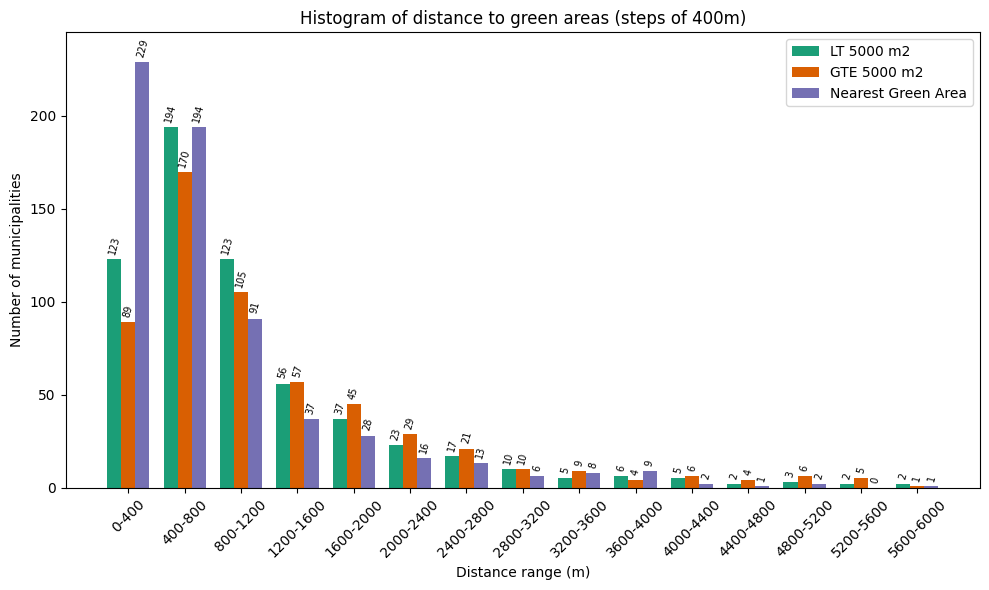

In [136]:
# preparing histograms

# setting the bins
binMin = 400
bins = np.arange(0,6100,binMin)
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# setting the columns from the summary gdf
colsToHist = [col + '_mean' for col in columns]

# setting the histograms data (as a dictionary)
hist_data = {}

for col in colsToHist:
    # cutting the values into bins
    binned = pd.cut(gdf_summary[col], bins=bins, labels=labels, include_lowest=True)

    # count valus per bin
    hist_data[col] = binned.value_counts(sort=False)

# converting the data for plotting
hist_df = pd.DataFrame(hist_data)
hist_df.index.name = 'Distance (m)'
hist_df = hist_df.reset_index()

# setting the plot
fig, ax = plt.subplots(figsize=(10,6))

# Plot grouped bars
x = np.arange(len(labels))
width = 0.25

# plotting the bars separatedly
barColors = ['#1b9e77','#d95f02','#7570b3']

col = colsToHist[0]
label = columnsDict[col.split('_mean')[0]]
ax.bar(x - width, hist_df[col], width=width, label=label, color=barColors[0])

col = colsToHist[1]
label = columnsDict[col.split('_mean')[0]]
ax.bar(x,         hist_df[col], width=width, label=label, color=barColors[1])

col = colsToHist[2]
label = columnsDict[col.split('_mean')[0]]
ax.bar(x + width, hist_df[col], width=width, label=label, color=barColors[2])

for i, col in enumerate(colsToHist):
    for j, value in enumerate(hist_df[col]):
        ax.text(x[j] + (i - 1) * width, value + 3, f'{value:.0f}', ha='center', fontsize=7, rotation=75)

# X-axis settings
ax.set_xticks(x)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticklabels(hist_df['Distance (m)'])
ax.set_xlabel('Distance range (m)')
ax.set_ylabel('Number of municipalities')
ax.set_ylim(0, 245)
ax.set_title(f'Histogram of distance to green areas (steps of {binMin}m)')
ax.legend()
plt.tight_layout()
plt.show()

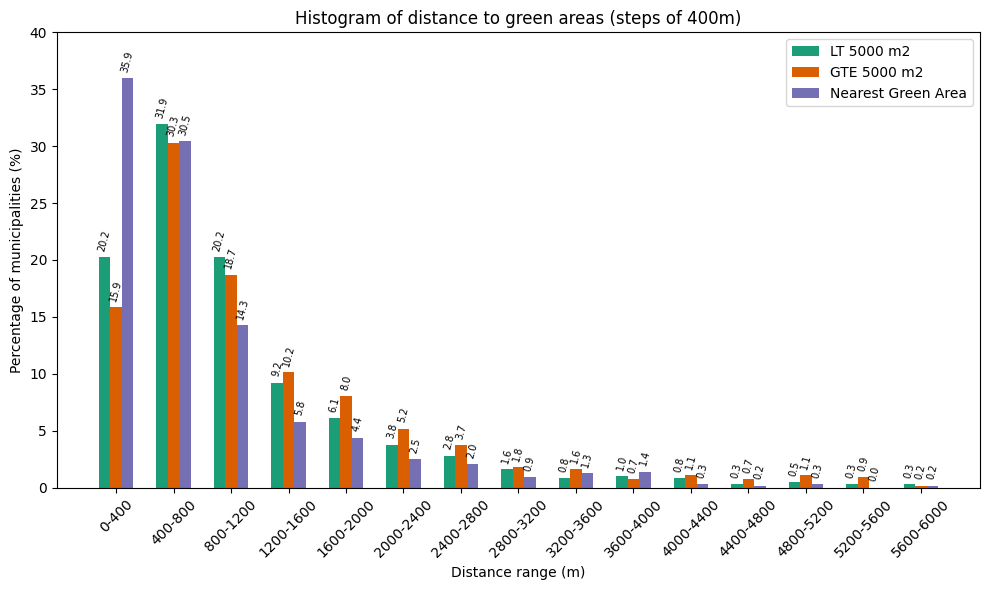

In [129]:
# plotting as percentages
hist_df[colsToHist] = hist_df[colsToHist].div(hist_df[colsToHist].sum()) * 100

# setting the plot
fig, ax = plt.subplots(figsize=(10,6))

# Plot grouped bars
x = np.arange(len(labels))
width = 0.2

# plotting the bars separatedly
barColors = ['#1b9e77','#d95f02','#7570b3']

col = colsToHist[0]
label = columnsDict[col.split('_mean')[0]]
ax.bar(x - width, hist_df[col], width=width, label=label, color=barColors[0])

col = colsToHist[1]
label = columnsDict[col.split('_mean')[0]]
ax.bar(x,         hist_df[col], width=width, label=label, color=barColors[1])

col = colsToHist[2]
label = columnsDict[col.split('_mean')[0]]
ax.bar(x + width, hist_df[col], width=width, label=label, color=barColors[2])

for i, col in enumerate(colsToHist):
    for j, value in enumerate(hist_df[col]):
        ax.text(x[j] + (i - 1) * width, value + 0.6, f'{value:.1f}', ha='center', fontsize=7, rotation=75)

# X-axis settings
ax.set_xticks(x)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticklabels(hist_df['Distance (m)'])
ax.set_xlabel('Distance range (m)')
ax.set_ylabel('Percentage of municipalities (%)')
ax.set_ylim(0, 40)
ax.set_title(f'Histogram of distance to green areas (steps of {binMin}m)')
ax.legend()
plt.tight_layout()
plt.show()

In [76]:
# reading the shp of municipalities
gdf_mun = gpd.read_file(munPath)
gdf_mun = gdf_mun[['CD_MUN', 'NM_MUN', 'NM_RGI', 'geometry']]
gdf_mun['CD_MUN'] = gdf_mun['CD_MUN'].astype(str)

# # uncomment to see the gdf
# gdf_mun.head()

In [77]:
# merging gdf and df
gdf_mun_summary = gdf_mun.merge(gdf_summary, left_on="CD_MUN", right_on="CD_MUN_y")

# # uncomment to see the gdf
# gdf_mun_summary.head()

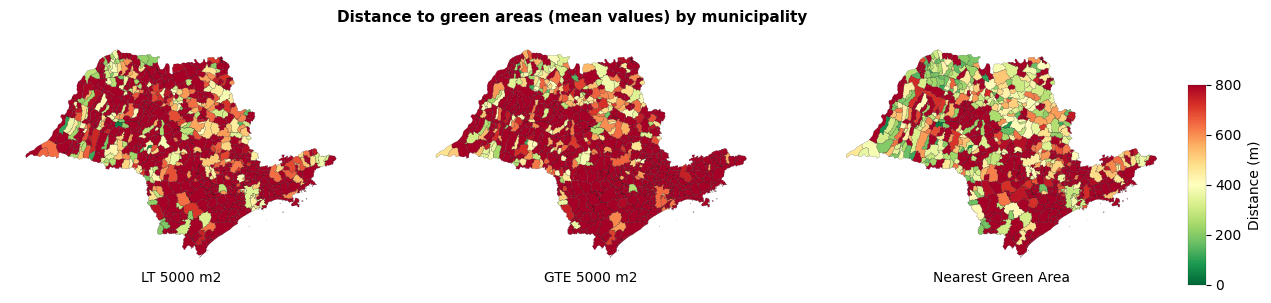

In [84]:
# set the gdf
gdf_selected = gdf_mun_summary

# avoiding inf and nan
gdf_selected = gdf_selected.replace([np.inf, -np.inf], np.nan)
gdf_selected = gdf_selected.fillna(vmax)

# columns to plot of the summary dataframe
summaryColsToPlot = [col + '_mean' for col in columns]

# Create plots
sizeBalance = 5
fig, axes = plt.subplots(1, len(summaryColsToPlot), figsize=(sizeBalance * len(summaryColsToPlot), 2*sizeBalance))
if len(columns) == 1:
    axes = [axes]

for i, col in enumerate(summaryColsToPlot):
    ax = axes[i]
    gdf_selected.plot(
        column=col,
        cmap=cmap,
        linewidth=0.1,
        edgecolor='black',
        ax=ax,
        legend=False,
        norm=norm
    )

    ax.set_title(columnsDict[col.split('_mean')[0]],fontsize=10, y=-0.085)
    ax.axis('off')

# plt.tight_layout()
# plt.show()

# Adjust title position
fig.suptitle("Distance to green areas (mean values) by municipality", fontsize=11, fontweight='bold', y=0.625)

# add shared colorbar
cbar_ax = fig.add_axes([0.91, 0.35, 0.012, 0.2])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Distance (m)')
cbar.outline.set_linewidth(0.1)

# adjusting the plotting
# plt.tight_layout(rect=[0, 0, 0.95, 1])
fig.subplots_adjust(top=0.85)
plt.show()

In [86]:
# obtaining statistics by region
gdf_summary2 = gdf_mun_summary.groupby(['NM_RGI'])[summaryColsToPlot].agg(['mean']).reset_index()
# gdf_summary2.head()

# flatten the multiIndex columns in gdf_summary2
gdf_summary2.columns = ['_'.join(col).strip('_') for col in gdf_summary2.columns.values]

# dissolving mun gdf to obtaint statistics by region
gdf_reg = gdf_mun.dissolve(by='NM_RGI').reset_index()

# merging the results
gdf_reg_summary = gdf_reg.merge(gdf_summary2, left_on="NM_RGI", right_on="NM_RGI")
# gdf_reg_summary.head()

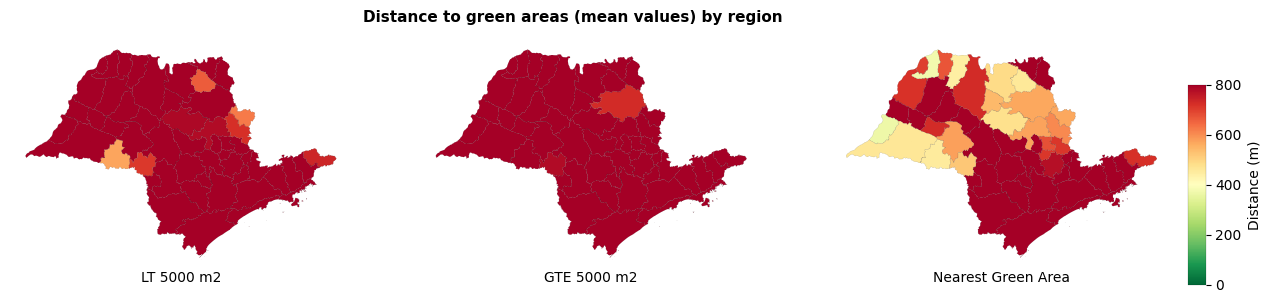

In [87]:
# set the gdf
gdf_selected = gdf_reg_summary

# avoiding inf and nan
gdf_selected = gdf_selected.replace([np.inf, -np.inf], np.nan)
gdf_selected = gdf_selected.fillna(vmax)

# columns to plot of the summary dataframe
summaryColsToPlotReg = [col + '_mean_mean' for col in columns]

# Create plots
sizeBalance = 5
fig, axes = plt.subplots(1, len(summaryColsToPlotReg), figsize=(sizeBalance * len(summaryColsToPlotReg), 2*sizeBalance))
if len(columns) == 1:
    axes = [axes]

for i, col in enumerate(summaryColsToPlotReg):
    ax = axes[i]
    gdf_selected.plot(
        column=col,
        cmap=cmap,
        linewidth=0.05,
        edgecolor='black',
        ax=ax,
        legend=False,
        norm=norm
    )

    ax.set_title(columnsDict[col.split('_mean_mean')[0]],fontsize=10, y=-0.085)
    ax.axis('off')

# plt.tight_layout()
# plt.show()

# Adjust title position
fig.suptitle("Distance to green areas (mean values) by region", fontsize=11, fontweight='bold', y=0.625)

# add shared colorbar
cbar_ax = fig.add_axes([0.91, 0.35, 0.012, 0.2])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Distance (m)')
cbar.outline.set_linewidth(0.1)

# adjusting the plotting
# plt.tight_layout(rect=[0, 0, 0.95, 1])
fig.subplots_adjust(top=0.85)
plt.show()